# Modified Pyramid Pooling Module-Based Semi-Siamese Network (PPM-SSNet) for Classifying Post Disaster Building Damage Label

Exam Code: LTKB8


In this Jupyter Notebook, I explore the implementation of the Pyramid Pooling Module-Based Semi-Siamese Network (PPM-SSNet), as proposed by Bai et al. (2020), using the xBD dataset.

The xBD dataset consists of pre- and post-disaster satellite imagery and includes over 850,000 building polygons affected by six types of natural disasters: earthquakes, tsunamis, volcanic eruptions, floods, wildfires, and hurricanes. The dataset spans a total area of more than 45,000 square kilometers across various global regions.

To categorize building damage levels, the xBD dataset employs the Joint Damage Scale (JDS) (Gupta et al., 2019; Defense Innovation Unit, n.d.), which includes the following classifications:

No Damage: Structure is undisturbed, with no visible signs of water exposure, structural damage, shingle damage, or burn marks.

Minor Damage: Building is partially burned, has water surrounding the structure, nearby volcanic flow, missing roof elements, or visible cracks.

Major Damage: Significant structural issues such as partial wall or roof collapse, encroaching volcanic flow, or the building being surrounded by water or mud.

Destroyed: The structure is scorched, completely collapsed, partially or fully submerged in water or mud, or entirely absent.

This research aims to assess the performance of PPM-SSNet in accurately classifying post-disaster building damage using this rich and diverse dataset.

Regarding PPM-SSNet, Bai et al. (2020) developed the model by integrating dilated convolutions, a squeeze-and-excitation (SE) attention mechanism, and a pyramid pooling module (PPM). The model achieved F1 scores of 0.90, 0.41, 0.65, and 0.70 for the undamaged, minor-damaged, major-damaged, and destroyed building classes, respectively, when evaluated on the xBD dataset. These results demonstrate strong performance, particularly considering the class imbalance inherent in the xBD dataset. Given that the original model utilizes both pre- and post-disaster imagery, this study tries to do explanatory research of modifying the PPM-SSNet using only post-disaster images. Due to time constraints and hardware limitations, a simplified version of the model will be implemented.

## 1.0 Setting up Libraries and Working Paths

In [ ]:
!pip install torchmetrics
import pandas as pd
import torch
import os
import json
import numpy as np
from collections import Counter
from PIL import Image
from shapely import wkt
from shapely.geometry import Polygon
from skimage.draw import polygon
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torchmetrics.functional as MF
from sklearn.model_selection import train_test_split
from torchsummary import summary
from skimage.draw import polygon as draw_polygon
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

print("CUDA Available:", torch.cuda.is_available())

from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

At this stage, a primary working directory was established using Google Drive for data management and collaboration. The xBD dataset was uploaded to this directory, which includes 2,799 training images, 933 validation images, and 933 test images, each with a resolution of 1024×1024 pixels (Defense Innovation Unit, n.d.). Due to time constraints, this study utilizes only the 2,799 training images. From the training images, 80% is allocated for model training and 20% for testing. Further details on dataset preparation and explanation are provided in the following sections.

Furthermore, the filenames in the training dataset encode information about the disaster location and type, a unique numerical identifier for each image pair, and a label indicating whether the image was captured pre- or post- disaster. These files are stored in the "images" folder as RGB PNG format images. The corresponding building annotations are provided in the "labels" folder as JSON files, which contain polygon data in Well-Known Text (WKT) format along with relevant metadata for each view. The "targets" folder includes pixel-wise ground truth masks representing building footprints derived from the annotations (Defense Innovation Unit, n.d.).

In [ ]:
base_path = '/content/drive/My Drive/Colab Notebooks/GEOG0125-Data/'

# Directories for train, hold, and test sets
train_images_path = os.path.join(base_path, 'train_images_labels_targets/train/images/')
train_labels_path = os.path.join(base_path, 'train_images_labels_targets/train/labels/')
train_targets_path = os.path.join(base_path, 'train_images_labels_targets/train/targets/')


imgs_path = [x for x in os.listdir(train_images_path) if 'post' in x]
targets_path = [x for x in os.listdir(train_targets_path) if 'post' in x]

print(f"Number of post-disaster images in training set: {len(imgs_path)}")

# Code Source:(Adinata, 2023; Benedict et al., 2024; OpenAI, 2025j)

Number of post-disaster images in training set: 2799


## 2.0 Pre-Process: Building & Mask Extraction

In this stage, I utilized 2,799 training images with a resolution of 1024×1024 pixels and extracted individual building instances at a resolution of 64×64 pixels. The extraction process was based on the JSON annotation files, which provided the bounding box coordinates and corresponding damage labels for each building.

Each extracted building was categorized based on its damage level and organized into separate directories within the training_classification_output/ folder on Google Drive. The categories included: 0 (No Damage), 1 (Minor Damage), 2 (Major Damage), 3 (Destroyed), and 4 (Unclassified).

Additionally, for every extracted building, relevant metadata was recorded, including the source image, as well as the building's location and shape within the original image. This metadata was compiled and saved in a CSV file titled training_crop_metadata.csv.

In addition, I applied the same process to a separate set of images intended for testing and visualization. These images are entirely distinct from the primary dataset of 2,799 images, of which 80% were allocated for training and 20% for testing. The separate test images were stored in the test_classification_output/ directory, with corresponding metadata saved in test_crop_metadata.csv.

In [ ]:
#Setting Directories
POST_IMAGE_PATH = train_images_path
POST_JSON_PATH = train_labels_path
OUTPUT_PATH = os.path.join(base_path, "training_classification_output/")
os.makedirs(OUTPUT_PATH, exist_ok=True)
CROP_SIZE=(64,64)

In [ ]:
# Debug mode
DEBUG_MODE = False
DEBUG_LIMIT = 100

# Damage label mapping
damage_dict = {
    "no-damage": 0,
    "minor-damage": 1,
    "major-damage": 2,
    "destroyed": 3,
    "un-classified": 4
}

# Create directories based on damage label
for i in range(len(damage_dict)):
    os.makedirs(os.path.join(OUTPUT_PATH, str(i)), exist_ok=True)

# Function for creating a mask based on polygon labels
def poly_to_mask(poly, shape):
    mask = np.zeros(shape, dtype=np.uint8) #Creates a blank black image (all zeros)
    if not poly.is_valid:
        poly = poly.buffer(0) #fixes invalid polygons if there are any
    if not poly.is_empty and isinstance(poly, Polygon): #checks if there are empty polygons and make sure it is polygons or multipolygons
        coords = np.array(poly.exterior.coords) #Get the outer boundary coordinates of the polygon and convert them to a NumPy array
        rr, cc = polygon(coords[:, 1], coords[:, 0], shape) #(y,x) coordinates since image indexing is (row, col)
        rr = np.clip(rr, 0, shape[0]-1) #Prevents out-of-bounds errors
        cc = np.clip(cc, 0, shape[1]-1) #Prevents out-of-bounds errors
        mask[rr, cc] = 1 #set building mask to 1
    return mask

output_idx = 0
metadata_records = [] #for containing metadata details
post_images = [f for f in os.listdir(POST_IMAGE_PATH) if "post" in f] #filters so that only post disaster pictures that will be processed

if DEBUG_MODE:
    print(f"Debug Mode ON: Limiting to first {DEBUG_LIMIT} crops.")

for img_file in tqdm(post_images): #Loops through all post-disaster image
    img_id = img_file.replace(".png", "")
    json_file = img_id.replace("img", "label") + ".json" #To ensure the right label file

    image_path = os.path.join(POST_IMAGE_PATH, img_file)
    json_path = os.path.join(POST_JSON_PATH, json_file)

    if not os.path.exists(json_path): #If the label file is missing, skip this image
        continue

    img = np.array(Image.open(image_path))
    h, w, _ = img.shape #Extracts height and width

    with open(json_path) as f:
        data = json.load(f) #Loads the JSON label

    features = data.get("features", {}).get("xy", []) #Extracts building geometries and metadata

    for feat in features: #Iterates over every building in that image
        props = feat.get("properties", {})
        dmg = props.get("subtype", "un-classified") #Maps damage label

        if dmg not in damage_dict:
            dmg = "un-classified" #if the subtype is missing or not known, assigns as un-classified
        cls = damage_dict[dmg]

        try:
            poly = wkt.loads(feat["wkt"])
        except:
            continue # skip broken shapes

        mask = poly_to_mask(poly, (h, w)) #Converts the polygon into a binary mask
        ys, xs = np.where(mask)

        if len(xs) == 0 or len(ys) == 0:
            continue #If the mask doesn't cover anything, skip it

        x_min, x_max = xs.min(), xs.max()
        y_min, y_max = ys.min(), ys.max()
        cropped_img = img[y_min:y_max, x_min:x_max] #Finds the tightest bounding box around the mask and crops that region from the original image

        save_path = os.path.join(OUTPUT_PATH, str(cls), f"{output_idx}.png") #Saves the cropped building image to a class-specific folder
        Image.fromarray(cropped_img).resize(CROP_SIZE, Image.BILINEAR).save(save_path)

        # Save metadata
        metadata_records.append({
            "crop_filename": f"{output_idx}.png",
            "original_image": img_file,
            "building_id": output_idx,
            "true_label": cls,
            "x_min": x_min,
            "y_min": y_min,
            "x_max": x_max,
            "y_max": y_max,
            "polygon_wkt": feat["wkt"]
        })

        output_idx += 1

        if DEBUG_MODE and output_idx >= DEBUG_LIMIT:
            print("Reached debug crop limit. Stopping early.")
            break
    if DEBUG_MODE and output_idx >= DEBUG_LIMIT:
        break

# Save metadata to CSV
metadata_df = pd.DataFrame(metadata_records)
metadata_df.to_csv(os.path.join(OUTPUT_PATH, "training_crop_metadata.csv"), index=False)

#Code source: (OpenAI, 2025q; OpenAI, 2025e)

100%|██████████| 2799/2799 [30:49<00:00,  1.51it/s]


Total building crops saved: 162787
Metadata saved to: /content/drive/My Drive/Colab Notebooks/GEOG0125-Data/training_classification_output/crop_metadata.csv
Exists: True


In [ ]:
test_images_path = os.path.join(base_path, 'test_images_labels_targets/test/images/')
test_labels_path = os.path.join(base_path, 'test_images_labels_targets/test/labels/')
test_targets_path = os.path.join(base_path, 'test_images_labels_targets/test/targets/')
TEST_POST_IMAGE_PATH = test_images_path
TEST_POST_JSON_PATH = test_labels_path
TEST_OUTPUT_PATH = os.path.join(base_path, "test_classification_output/")
os.makedirs(TEST_OUTPUT_PATH, exist_ok=True)
CROP_SIZE=(64,64)

In [ ]:
# Debug mode
DEBUG_MODE = False
DEBUG_LIMIT = 100

# Damage label
damage_dict = {
    "no-damage": 0,
    "minor-damage": 1,
    "major-damage": 2,
    "destroyed": 3,
    "un-classified": 4
}

# Function for creating a mask based on polygon labels
def poly_to_mask(poly, shape):
    """Convert polygon to binary mask."""
    mask = np.zeros(shape, dtype=np.uint8) #Creates a blank black image (all zeros)
    if not poly.is_valid:
        poly = poly.buffer(0) #fixes invalid polygons if there are any
    if not poly.is_empty and isinstance(poly, Polygon): #checks if there are empty polygons and make sure it is polygons or multipolygons
        coords = np.array(poly.exterior.coords) #Get the outer boundary coordinates of the polygon and convert them to a NumPy array
        rr, cc = polygon(coords[:, 1], coords[:, 0], shape) #(y,x) coordinates since image indexing is (row, col)
        rr = np.clip(rr, 0, shape[0]-1) #Prevents out-of-bounds errors (row)
        cc = np.clip(cc, 0, shape[1]-1) #Prevents out-of-bounds errors (column)
        mask[rr, cc] = 1 #set building mask to 1
    return mask

# Create directories based on damage label
for i in range(len(damage_dict)):
    os.makedirs(os.path.join(TEST_OUTPUT_PATH , str(i)), exist_ok=True)

output_idx = 0
metadata_records = [] #for containing metadata details
post_images = [f for f in os.listdir(TEST_POST_IMAGE_PATH) if "post" in f] #filters so that only post disaster pictures that will be processed

if DEBUG_MODE:
    print(f"Debug Mode ON: Limiting to first {DEBUG_LIMIT} crops.")

for img_file in tqdm(post_images): #Loops through all post-disaster image
    img_id = img_file.replace(".png", "")
    json_file = img_id.replace("img", "label") + ".json" #To ensure the right label file

    image_path = os.path.join(TEST_POST_IMAGE_PATH, img_file)
    json_path = os.path.join(TEST_POST_JSON_PATH, json_file)

    if not os.path.exists(json_path): #If the label file is missing, skip this image
        continue

    img = np.array(Image.open(image_path))
    h, w, _ = img.shape #Extracts height and width

    with open(json_path) as f:
        data = json.load(f) #Loads the JSON label


    features = data.get("features", {}).get("xy", []) #Extracts building geometries and metadata

    for feat in features: #Iterates over every building in that image
        props = feat.get("properties", {})
        dmg = props.get("subtype", "un-classified") #Maps damage label

        if dmg not in damage_dict:
            dmg = "un-classified" #if the subtype is missing or not known, assigns as un-classified

        cls = damage_dict[dmg]

        try:
            poly = wkt.loads(feat["wkt"])
        except:
            continue  # skip broken shapes

        mask = poly_to_mask(poly, (h, w)) #Converts the polygon into a binary mask
        ys, xs = np.where(mask)

        if len(xs) == 0 or len(ys) == 0:
            continue #If the mask doesn't cover anything, skip it

        x_min, x_max = xs.min(), xs.max()
        y_min, y_max = ys.min(), ys.max()
        cropped_img = img[y_min:y_max, x_min:x_max] #Finds the tightest bounding box around the mask and crops that region from the original image

        test_save_path = os.path.join(TEST_OUTPUT_PATH, str(cls), f"{output_idx}.png") #Saves the cropped building image to a class-specific folder
        Image.fromarray(cropped_img).resize(CROP_SIZE, Image.BILINEAR).save(test_save_path)
        output_idx += 1

        # Save metadata
        metadata_records.append({
            "crop_filename": f"{output_idx}.png",
            "original_image": img_file,
            "building_id": output_idx,
            "true_label": cls,
            "x_min": x_min,
            "y_min": y_min,
            "x_max": x_max,
            "y_max": y_max,
            "polygon_wkt": feat["wkt"]
        })

        output_idx += 1

        if DEBUG_MODE and output_idx >= DEBUG_LIMIT:
            print("Reached debug crop limit. Stopping early.")
            break
    if DEBUG_MODE and output_idx >= DEBUG_LIMIT:
        break

# Save metadata to CSV
metadata_df = pd.DataFrame(metadata_records)
metadata_df.to_csv(os.path.join(TEST_OUTPUT_PATH, "test_crop_metadata.csv"), index=False)


#Code source: (OpenAI, 2025q; OpenAI, 2025e)

## 3.0 Data and Parameter Preparation

In this study, a modified version of the PPM-SSNet model is utilized for damage classification. The modification is different from the original implementation, which uses a Siamese network architecture to compare pre- and post-disaster images. In this case, only post-disaster images are utilized, and therefore the Siamese operation is omitted. This decision was made to focus solely on classifying post-disaster imagery based on the damage labels associated with each building, as provided in the dataset.

As mentioned before, the PPM-SSNet utilized Dilated convolutions, Squeeze-and-Excitation attention mechanism, and Pyramid Pooling Module. Dilated convolutions are incorporated to enhance the receptive field of the model, allowing it to capture both global features—such as the contours of objects—and local features, including texture details (Bai et al., 2020; Li et al., 2021). This multi-scale feature extraction is critical for identifying varying levels of structural damage.

To further improve classification accuracy, the model integrates a Squeeze-and-Excitation (SE) attention mechanism. This component enables the network to emphasize informative features while suppressing less relevant ones, thereby reducing ambiguity in estimating damage levels (Bai et al., 2020).

The Pyramid Pooling Module (PPM) is employed to extract features at multiple spatial scales by pooling activation maps in a pyramidal fashion. Specifically in this case, the overall building shape are captured with smaller pyramid scales, while finer details of damaged structures are represented at larger scales, thus providing strong performance in pixel-level prediction tasks (Bai et al., 2020; Zhao et al., 2017). These are the main reasons why the author chose to utilize this method for the building damage classification task. A detailed explanation of the model modifications will be provided in a subsequent section.



### 3.1 Data Loading

After extracting the labeled building masks, all cropped 64×64 images from the training_classification_output/ and validation_classification_output/ directories were downloaded as ZIP files from Google Drive. This step was taken to address the slow read/write performance associated with accessing files directly from Google Drive. By uploading the files locally to Google Colab, the author was able to significantly improve the training efficiency of the classification model.

In [ ]:
#uploading local files after extraction
from google.colab import files
uploaded = files.upload()

#upload these files: training_classification_output and training_classification_output

Saving training_classification_output.zip to training_classification_output.zip


In [ ]:
%cd /content

# Step 2: Clean and create destination folders
!rm -rf /content/training_classification_output #removing directory if it exist already
!mkdir -p /content/training_classification_output #make new directory

#Unzip training dataset
!unzip -q "training_classification_output.zip" -d /content/training_classification_output

if os.path.exists("/content/training_classification_output/training_classification_output"):
    !mv /content/training_classification_output/training_classification_output/* /content/training_classification_output/
    !rm -rf /content/training_classification_output/training_classification_output

train_dir = "/content/training_classification_output"

#Code source: (OpenAI, 2025s)


/content


In terms of preprocessing parameters, the image size was resized from 64×64 to 224×224 pixels to match the standard input dimensions commonly used for convolutional neural networks (CNNs) (Perez, Tah, & Mosavi, 2019). A batch size of 32 and num_workers set to 4 were employed to improve training efficiency and expedite both image loading and batch preparation (Adinata, 2023). The model was trained for 30 epochs to observe the progression of loss and accuracy over time.

To enhance model robustness, various data augmentation techniques were applied to the input images, including random flipping, rotation, translation, side view transformation, and zooming, along with adjustments to saturation, contrast, and brightness. These augmentations are considered essential due to the inherent variability in real-world imagery, such as differences in color composition, angles, and zoom levels. By applying these transformations, the model is better equipped to generalize across diverse inputs (Wu et al., 2021; Benedict et al., 2024; Chen, 2020).

A learning rate of 0.0002 was used, following the optimization strategy adopted in prior studies (Wu et al., 2021; Chen, 2020). Considering the class imbalance present in the xBD dataset, a stratified split was implemented to ensure proportional representation of all classes in both the training and validation sets. The data was split into 80% training and 20% validation, resulting in a final distribution of 130,229 training images and 32,558 validation images.

In [ ]:
#Parameters
TRAINING_DATASET = "/content/training_classification_output"
IMG_SIZE = 224 #(Adinata, 2023; Perez, Tah and Mosavi, 2019; Law and Lin, 2025)
NUM_CLASSES = 5
BATCH_SIZE = 32 #(Adinata, 2023)
EPOCHS = 30 #the epoch was set to 30 by the author in order to see the progression of the loss and accuracy of the model
LEARNING_RATE = 0.0002 #(Wu et al., 2021; Chen, 2020)
NUMWORKERS = 4 #(Adinata, 2023)
VAL_SPLIT = 0.2 #(Pi, Nath and Behzadan, 2020; Chen, 2020)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Transforms ===
train_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE), #resize image
    transforms.RandomHorizontalFlip(p=0.5), #horizontal flips randomly with 50% probabilities
    transforms.RandomVerticalFlip(p=0.5), #vertical flips randomly with 50% probabilities
    transforms.RandomRotation(degrees=30), #randomly rotate with −30° to +30°
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05), #randomly adjust the brightness, contrast, saturation, and hue of the images
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)), #randomly adjust the scale
    transforms.ToTensor(), #transform it to a PyTorch tensor
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) #applies mean-std normalization which follows ImageNet normalization stats(Law and Lin, 2025)
])

test_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE), #resize image
    transforms.ToTensor(), #transform it to a PyTorch tensor
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) #(Law and Lin, 2025)
])


raw_dataset = datasets.ImageFolder(root=TRAINING_DATASET)

# Stratified split in order to make all the class present in both training and validation sets (due to heavy class imbalanced)
targets = [label for _, label in raw_dataset.samples]
train_idx, test_idx = train_test_split(
    np.arange(len(raw_dataset)),
    test_size=VAL_SPLIT,
    stratify=targets,
    random_state=42
)

train_dataset = Subset(datasets.ImageFolder(root=TRAINING_DATASET, transform=train_transform), train_idx)
test_dataset = Subset(datasets.ImageFolder(root=TRAINING_DATASET, transform=test_transform), test_idx)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUMWORKERS)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUMWORKERS)


print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Code source: (Benedict et al., 2024; Adinata, 2023; Law and Lin, 2025; OpenAI, 2025o; OpenAI, 2025c)


FileNotFoundError: [Errno 2] No such file or directory: '/content/training_classification_output'

### 3.2 Sanity Check train-test split

In [ ]:
# Label distribution in train set
train_targets = [train_dataset.dataset.samples[i][1] for i in train_dataset.indices]
print("Train Split Class Distribution")
print(Counter(train_targets))

# Label distribution in test set
test_targets = [test_dataset.dataset.samples[i][1] for i in test_dataset.indices]
print("Test Split Class Distribution")
print(Counter(test_targets))

# Sample image paths and labels from test set
print("Sample Test Images and Labels")
for i in range(5):
    idx = test_dataset.indices[i]
    path, label = test_dataset.dataset.samples[idx]
    print(f"{path} --> Label: {label}")

# Class index mapping
print("Class to Index Mapping")
print(test_dataset.dataset.class_to_idx)

# Duplicate check between train and test
train_paths = [train_dataset.dataset.samples[i][0] for i in train_dataset.indices]
test_paths = [test_dataset.dataset.samples[i][0] for i in test_dataset.indices]

train_set = set(train_paths)
test_set = set(test_paths)
overlap = train_set.intersection(test_set)

if overlap:
    print(f"Found {len(overlap)} overlapping images in both train and test sets")
    print("Example duplicates:", list(overlap)[:5])
else:
    print("No duplicate images between train and test sets")

# 6. Internal duplicate check
if len(train_paths) != len(set(train_paths)):
    print("Duplicate paths found within training set")
else:
    print("No duplicates within training set")

if len(test_paths) != len(set(test_paths)):
    print("Duplicate paths found within test set")
else:
    print("No duplicates within test set")

#Code source: (OpenAI, 2025k)


NameError: name 'train_dataset' is not defined

### 3.3 Focal Loss

Focal Loss, an extension of cross-entropy loss, was employed to enhance model performance in the presence of severe class imbalance (Benedict et al., 2024). Specifically, it was applied to the damage scale classification task to address the disproportionate representation among classes. Additionally, to further mitigate class imbalance, Class-wise Alpha Weights were incorporated during training. This method assigns higher weights to underrepresented (rare) classes and lower weights to overrepresented (frequent) classes, thereby improving the model’s ability to learn from less frequent categories (Bai et al., 2020).

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=1, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

        if isinstance(alpha, (float, int)): #converts the alpha parameter into a PyTorch tensor which allows for different weight settings for the classes
            self.alpha = torch.Tensor([alpha, 1 - alpha]) # single number will be assumed to be the weight for the positive class and 1 - alpha will be the weight for the negative class
        elif isinstance(alpha, list): #directly converts this list into a PyTorch tensor if alpha is a list
            self.alpha = torch.Tensor(alpha)

    def forward(self, input, target):
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1) #(N, C, HW)
            input = input.transpose(1, 2) #(N, C, HW) to (N, HW, C)
            input = input.contiguous().view(-1, input.size(2)) #(NHW, C) represents every spatial location as a separate data point and make it suitable for independent classification

        target = target.view(-1, 1)

        logpt = F.log_softmax(input, dim=1) #softmax function to the input tensor
        logpt = logpt.gather(1, target) #picks out the log probabilities corresponding to the true class labels for each entry
        logpt = logpt.view(-1) #flattening the Log Probabilities
        pt = Variable(logpt.data.exp()) #converts log probabilities back into actual probabilities

        if self.alpha is not None: #checks if alpha is defined
            if self.alpha.type() != input.data.type(): #checks if the data type of alpha matches the data type of input
                self.alpha = self.alpha.to(input.device)
            at = self.alpha.gather(0, target.view(-1)) #contains the alpha values corresponding to each target class
            logpt = logpt * Variable(at) #multiplies alpha values with the log probabilities to scale the log probabilities by class-specific weights

        loss = -1 * (1 - pt) ** self.gamma * logpt #Focal Loss Calculation
        return loss.mean() if self.size_average else loss.sum() #averages the loss


# Class-wise Alpha Weights
class_counts = torch.tensor([117426, 14980, 14161, 13227, 2993], dtype=torch.float32) #number of images for each class
inv_freqs = 1.0 / class_counts # Inverse frequencies so that smaller classes will be assigned with higher weights
alpha_weights = (inv_freqs / inv_freqs.sum()).tolist() #normalization of weights

# Instantiate Final Loss Function
loss_fn = FocalLoss(gamma=1.0, alpha=alpha_weights).to(device)

#Code source: (Benedict et al., 2024) #(Bai et al., 2020; mlyg, 2022; OpenAI, 2025r)

### 3.4 Set up the training/testing loop

In [ ]:

def set_parameter_requires_grad(model, feature_extracting): #toggle the gradient computation settings to perform feature extraction using a pre-trained model without modifying the weights
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def train_loop(dataloader, model, loss_fn, optimizer, epoch, num_classes, device):
    model.train() #Puts the model in training mode
    total_loss = 0 #Initializes metrics over the epoch
    total_acc = 0 #Initializes metrics over the epoch
    total_prec = 0 #Initializes metrics over the epoch
    total_rec = 0 #Initializes metrics over the epoch
    num_batches = len(dataloader)

    loop = tqdm(dataloader, desc=f"Epoch {epoch} - Training", leave=False) #progress bar for real-time feedback
    for X, y in loop:
        X, y = X.to(device), y.to(device)
        pred = model(X) #model performs a forward pass
        loss = loss_fn(pred, y) #loss function

        optimizer.zero_grad() #clears old gradients
        loss.backward() #backpropagation
        optimizer.step() #updates the model parameters

        acc = MF.accuracy(pred, y, task='multiclass', num_classes=num_classes, average='macro') #Computes macro-averaged accuracy, which is better for imbalanced class datasets like xBD
        prec = MF.precision(pred, y, task='multiclass', num_classes=num_classes, average='macro') #Computes macro-averaged accuracy, which is better for imbalanced class datasets like xBD
        rec = MF.recall(pred, y, task='multiclass', num_classes=num_classes, average='macro') #Computes macro-averaged accuracy, which is better for imbalanced class datasets like xBD

        total_loss += loss.item() #accumulates metrics over loop
        total_acc += acc #accumulates metrics over loop
        total_prec += prec #accumulates metrics over loop
        total_rec += rec #accumulates metrics over loop

        loop.set_postfix(loss=loss.item(), acc=acc.item(), prec=prec.item(), rec=rec.item()) #update Progress Bar

    avg_loss = total_loss / num_batches #Calculates metrics averages
    avg_acc = total_acc / num_batches #Calculates metrics averages
    avg_prec = total_prec / num_batches #Calculates metrics averages
    avg_rec = total_rec / num_batches #Calculates metrics averages
    avg_f1 = 2 * (avg_prec * avg_rec) / (avg_prec + avg_rec + 1e-8) #Calculates metrics averages

    return {
        'loss': avg_loss,
        'accuracy': avg_acc,
        'precision': avg_prec,
        'recall': avg_rec,
        'f1_score': avg_f1
    }

def test_loop(dataloader, model, loss_fn, num_classes, device):
    model.eval() #Puts the model in eval mode
    total_loss = 0 #Initializes metrics over the epoch
    total_acc = 0 #Initializes metrics over the epoch
    total_prec = 0 #Initializes metrics over the epoch
    total_rec = 0 #Initializes metrics over the epoch

    preds_all = []
    targets_all = []

    with torch.no_grad():
        loop = tqdm(dataloader, desc="Testing", leave=False) #progress bar for real-time feedback
        for X, y in loop:
            X, y = X.to(device), y.to(device)
            pred = model(X) #model performs a forward pass
            loss = loss_fn(pred, y) #loss function

            acc = MF.accuracy(pred, y, task='multiclass', num_classes=num_classes, average='macro') #Computes macro-averaged accuracy, which is better for imbalanced class datasets like xBD
            prec = MF.precision(pred, y, task='multiclass', num_classes=num_classes, average='macro') #Computes macro-averaged accuracy, which is better for imbalanced class datasets like xBD
            rec = MF.recall(pred, y, task='multiclass', num_classes=num_classes, average='macro') #Computes macro-averaged accuracy, which is better for imbalanced class datasets like xBD

            total_loss += loss.item() #accumulates metrics over loop
            total_acc += acc #accumulates metrics over loop
            total_prec += prec #accumulates metrics over loop
            total_rec += rec  #accumulates metrics over loop

            preds_all.append(pred)
            targets_all.append(y)

    #Stores model outputs and true labels for the entire epoch
    preds_all = torch.cat(preds_all)
    targets_all = torch.cat(targets_all)

    roc_auc = MF.auroc(preds_all, targets_all, task='multiclass', num_classes=num_classes, average='macro')

    avg_loss = total_loss / len(dataloader) #Calculates metrics averages
    avg_acc = total_acc / len(dataloader) #Calculates metrics averages
    avg_prec = total_prec / len(dataloader) #Calculates metrics averages
    avg_rec = total_rec / len(dataloader) #Calculates metrics averages
    avg_f1 = 2 * (avg_prec * avg_rec) / (avg_prec + avg_rec + 1e-8) #Calculates metrics averages

    return {
        'loss': avg_loss,
        'accuracy': avg_acc,
        'precision': avg_prec,
        'recall': avg_rec,
        'f1_score': avg_f1,
        'rocauc': roc_auc
    }

def add_history(history_list, train_history, val_result): #appends the latest metrics for the current epoch for both train and test function
    history_list['loss'].append(train_history['loss'])
    history_list['acc'].append(train_history['accuracy'].item())
    history_list['prec'].append(train_history['precision'].item())
    history_list['rec'].append(train_history['recall'].item())
    history_list['f1'].append(train_history['f1_score'].item())

    history_list['val_loss'].append(val_result['loss'])
    history_list['val_acc'].append(val_result['accuracy'].item())
    history_list['val_prec'].append(val_result['precision'].item())
    history_list['val_rec'].append(val_result['recall'].item())
    history_list['val_f1'].append(val_result['f1_score'].item())
    history_list['rocauc'].append(val_result['rocauc'].item())

    return history_list

def print_history(history: dict):
    print(f"Train  - acc: {history['acc'][-1]:.3f} | prec: {history['prec'][-1]:.3f} | rec: {history['rec'][-1]:.3f} | f1: {history['f1'][-1]:.3f}")
    print(f"Val    - acc: {history['val_acc'][-1]:.3f} | prec: {history['val_prec'][-1]:.3f} | rec: {history['val_rec'][-1]:.3f} | f1: {history['val_f1'][-1]:.3f}")


#Code source: (Law and Lin, 2025; Adinata, 2023; Benedict et al., 2024; OpenAI, 2025d)

## 4.0 Modified Pyramid Pooling Module-Based Semi-Siamese Network (PPM-SSNet)

### 4.1 Model Preparation

In this study, the xBD dataset is utilized in a simplified approach that differs from the original PPM-SSNet model proposed by Bai et al. (2020). As the xBD dataset already includes annotated building labels, the model directly uses these annotations to extract individual buildings and classify their damage levels. This streamlined process eliminates the need for generating localization masks, which were an integral part of Bai et al.’s original method. The aim is to evaluate the performance of a simpler training pipeline using only the post-disaster images provided in the dataset.

The first key difference from Bai et al. (2020) is the exclusive use of post-disaster imagery. While the original PPM-SSNet utilized both pre- and post-disaster images to generate localization masks and used those masks to enhance classification, this modified version skips that step and relies solely on post-disaster inputs.

The second difference lies in the network architecture. Due to limited computational resources, a shallower version of the model is implemented. The design of the model follows a progressive channel-doubling strategy, beginning with a small number of channels (input = 3 for RGB images, output = 16) and doubling at key stages. This design allows the network to gradually increase its representational capacity while minimizing memory consumption (Tan and Le, 2019).

The third modification involves the input image dimensions. Inspired by the method proposed by Benedict et al. (2024), each building is cropped from the original images to a 64×64 resolution. The corresponding labels from the xBD dataset’s JSON files are then used to assign damage classes to each cropped instance. This approach contrasts with Bai et al. (2020), who used full 1024×1024 images as input.

Given that the final input resolution is resized from 64×64 to 224×224, the use of extremely deep architectures or high-dimensional feature maps like the full-resolution images was viewed unnecessary and computationally excessive for the scope of this study. Therefore, the channel depth is intentionally capped at 128 to maintain a lightweight and efficient model.

In [ ]:
# Squeeze-and-Excitation (SE) Block #source: (Engelberts, 2018; Bai et al., 2020; OpenAI, 2025n)
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1) #Applies an adaptive average pooling
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction), #Reduces the number of features
            nn.ReLU(inplace=True), #ReLU with improvement on memory efficiency
            nn.Linear(channels // reduction, channels), #Increases the number of features back
            nn.Sigmoid() #Applies the sigmoid activation function
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c) #Applies the adaptive average pooling to batch and channel
        y = self.fc(y).view(b, c, 1, 1) #reshaped back into the spatial format
        return x * y.expand_as(x) #scaled channels


# Residual Block (RB) #(Zhou, 2019) #source: (Chen, 2020; Bai et al., 2020; OpenAI, 2025n)
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, dilation=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, #first convolution
                               padding=dilation, dilation=dilation, bias=False)
        self.bn1 = nn.BatchNorm2d(out_ch) #first batch normalisation
        self.relu = nn.ReLU(inplace=True) #ReLU with improvement on memory efficiency
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=dilation, #second convolution
                               dilation=dilation, bias=False)
        self.bn2 = nn.BatchNorm2d(out_ch) #second batch normalisation

        self.shortcut = nn.Identity() #identity mapping
        if stride != 1 or in_ch != out_ch: #adjust the dimensionality and/or resolution
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)


# Residual Block V2 (RB′) #source: (Bai et al., 2020; OpenAI, 2025n)
class ResidualBlockV2(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, dilation=1):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_ch)
        )
        self.block = ResidualBlock(out_ch, out_ch, stride=1, dilation=dilation) #applied the previous residual block

    def forward(self, x):
        x = self.initial(x)
        return self.block(x)
#RB’ has an additional convolutional layer + batch normalization layer, which is designed to change the number of channels or size of the input tensor if needed (Bai et al., 2020)


# Pyramid Pooling Module (PPM) #source: (Zhao, 2020; Bai et al., 2020; OpenAI, 2025n)
class PPM(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.stages = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool2d(output_size=s), #performs adaptive average pooling
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.ReLU(inplace=True) #ReLU with improvement on memory efficiency
            ) for s in [1, 2, 3, 6] #scales
        ])
        self.bottleneck = nn.Conv2d(in_channels + 4 * out_channels, out_channels, kernel_size=1) #convolutional layer that combines the input and the output from all pooling stages

    def forward(self, x):
        h, w = x.size(2), x.size(3)
        pooled = [F.interpolate(stage(x), size=(h, w), mode='bilinear', align_corners=True) #pools the feature map to different scales and then projects them back to the original size in each stage
                  for stage in self.stages]
        concat = torch.cat([x] + pooled, dim=1) #Concatenates the original feature map with all scaled feature map
        return self.bottleneck(concat)


# PPMNet #Source: (Tan and Le, 2019; Bai et al., 2020; OpenAI, 2025n)
class PPMNet(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        # Initial layer (shared low-level features)
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )

        # Feature extractor backbone
        self.layer2 = ResidualBlockV2(16, 32, stride=2, dilation=1)  # RB′ = Mid-Level Features: input channel 16 and output channel 32 with stride=2 and dilation=1
        self.layer3 = ResidualBlock(32, 32, stride=1, dilation=1)    # RB = Mid-Level Features: maintains input and output channel 32 with stride=2 and dilation=1
        self.se1 = SEBlock(32) #(SE) Block = adaptively reweights channel importance from RB' and RB

        self.layer4 = ResidualBlockV2(32, 64, stride=2, dilation=2)  # RB′ = High-Level Features: input channel 32 and output channel 64 with stride=2 and dilation=2
        self.layer5 = ResidualBlock(64, 64, stride=1, dilation=2)    # RB = High-Level Features: maintains input and output channel 64 with stride=2 and dilation=2
        self.se2 = SEBlock(64) #(SE) Block = adaptively enhances channel importance from RB' and RB

        self.layer6 = ResidualBlockV2(64, 128, stride=2, dilation=4) # RB′ = Global-Level Features: input channel 64 and output channel 128 with stride=2 and dilation=4
        self.layer7 = ResidualBlock(128, 128, stride=1, dilation=4)  # RB = Global-Level Features: maintains input and output channel 128 with stride=2 and dilation=4
        self.se3 = SEBlock(128) #(SE) Block = adaptively Refines channel importance from RB' and RB

        self.ppm = PPM(128, 128) #(PPM) block aggregates multi-scale context from global and local information from the previous 128 channels
        self.se4 = SEBlock(128) #(SE) Block = further refines the channel

        # Classification head
        self.classifier = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True), #ReLU with improvement on memory efficiency
            nn.Conv2d(64, num_classes, kernel_size=1)
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1)) #averages the spatial dimensions of the feature map to a single scalar per channel

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.se1(x)

        x = self.layer4(x)
        x = self.layer5(x)
        x = self.se2(x)

        x = self.layer6(x)
        x = self.layer7(x)
        x = self.se3(x)

        x = self.ppm(x)
        x = self.se4(x)

        x = self.classifier(x) #this is the part where is also started to differentiate from method of Bai et al. (2020). Instead of feeding in localization map, this method ends with global pooling and flatten it at the end (Hug, 2023)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # output: (B, num_classes)

        return x

#Code source: (Engelberts, 2018; Chen, 2020; Zhao, 2020; Tan and Le, 2019; Hug, 2023; Bai et al., 2020; OpenAI, 2025n; OpenAI, 2025b)

### 4.2 Model Training
The Adam optimizer was selected for training the model, as it is one of the most commonly used optimization algorithms in satellite image classification tasks (Chen, 2020; Nex et al., 2019; Wu et al., 2021; Zhao et al., 2024). The training history was recorded and saved in CSV format to enable visualization of the model's performance over 30 epochs.

In [ ]:
PPMNet_model = PPMNet(num_classes=NUM_CLASSES).to(device) #Initializes the model
optimizer = torch.optim.Adam(PPMNet_model.parameters(), lr=LEARNING_RATE) #Sets up the Adam optimizer

PPMNet_model_history = {
    'loss': [], 'acc': [], 'prec': [], 'rec': [], 'f1': [],
    'val_loss': [], 'val_acc': [], 'val_prec': [], 'val_rec': [], 'val_f1': [],
    'rocauc': []
} #for tracking training and validation metrics

#Training Loop
for epoch in range(EPOCHS): #Loops through 30 epochs
    train_result = train_loop(train_dataloader, PPMNet_model, loss_fn, optimizer, epoch + 1, NUM_CLASSES, device) #training the model
    val_result = test_loop(test_dataloader, PPMNet_model, loss_fn, NUM_CLASSES, device) #evaluates the model

    PPMNet_model_history = add_history(PPMNet_model_history, train_result, val_result) #Stores the results

print_history(PPMNet_model_history)

# Saves the training history
history_df = pd.DataFrame(PPMNet_model_history)
history_path = "/content/drive/MyDrive/Colab Notebooks/GEOG0125-Data/PPMNet_training_history_final.csv"
history_df.to_csv(history_path, index=False)
best_ppmnet_model_path = "/content/drive/MyDrive/Colab Notebooks/GEOG0125-Data/best_ppmnet_model_final.pth"
if not os.path.exists(best_ppmnet_model_path):
    torch.save(PPMNet_model.state_dict(), best_ppmnet_model_path)
    print(f"PPMNet model saved to: {best_ppmnet_model_path}")
else:
    print(f"PPMNet model not saved because file already exists.")

#Code source: (Adinata, 2023; Benedict et al., 2024; OpenAI, 2025p)

Epoch 1 - Training:   0%|          | 0/4070 [00:00<?, ?it/s]

Due to the extended training time, which can exceed 6.5 hours, the resulting model was saved at the best_ppmnet_model_path checkpoint. This saved model was then reloaded and evaluated using the same test dataloader used previously, in order to generate predictions for each individual image. The prediction results were stored in prediction_csv_path and subsequently merged with the metadata saved during the pre-processing stage. This allowed for a direct comparison between the model’s predictions and the ground truth labels.

In [ ]:
best_ppmnet_model_path = "/content/drive/MyDrive/Colab Notebooks/GEOG0125-Data/best_ppmnet_model_final.pth"
PPMNet_model = PPMNet(num_classes=NUM_CLASSES).to(device)
PPMNet_model.load_state_dict(torch.load(best_ppmnet_model_path, map_location=device)) #Loads the saved parameters
PPMNet_model.eval()

summary(PPMNet_model.cuda(), (3, IMG_SIZE, IMG_SIZE)) #ayer-by-layer summary of the model architecture

all_preds = []
all_targets = []
all_crop_filenames = []

image_paths = [s[0] for s in test_dataloader.dataset.dataset.samples] #Extracts the image file path from the original test dataloader

PPMNet_model.eval() # eval mode
with torch.no_grad():
    for i, (X, y) in enumerate(tqdm(test_dataloader, desc="Generating predictions")): #Loops through the test dataset
        X = X.to(device)
        outputs = PPMNet_model(X)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        targets = y.numpy()

        batch_start = i * test_dataloader.batch_size
        batch_end = batch_start + len(y)
        batch_filenames = image_paths[batch_start:batch_end]

        all_preds.extend(preds)
        all_targets.extend(targets)
        all_crop_filenames.extend([os.path.basename(p) for p in batch_filenames])


pred_df = pd.DataFrame({
    "crop_filename": all_crop_filenames,
    "true_label": all_targets,
    "predicted_label": all_preds
})

prediction_csv_path = "/content/drive/MyDrive/Colab Notebooks/GEOG0125-Data/predictions.csv"
if not os.path.exists(prediction_csv_path):
    pred_df.to_csv(prediction_csv_path, index=False)
    print(f"Predictions saved to: {prediction_csv_path}")
else:
    print(f"Predictions NOT saved because file already exists at: {prediction_csv_path}")

#Code source: (Law and Lin, 2025; OpenAI, 2025l)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]           2,368
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
            Conv2d-4         [-1, 32, 112, 112]             512
       BatchNorm2d-5         [-1, 32, 112, 112]              64
          Identity-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 32, 112, 112]           9,216
       BatchNorm2d-8         [-1, 32, 112, 112]              64
              ReLU-9         [-1, 32, 112, 112]               0
           Conv2d-10         [-1, 32, 112, 112]           9,216
      BatchNorm2d-11         [-1, 32, 112, 112]              64
             ReLU-12         [-1, 32, 112, 112]               0
    ResidualBlock-13         [-1, 32, 112, 112]               0
  ResidualBlockV2-14         [-1, 32, 1

Generating predictions:   3%|▎         | 33/1018 [00:02<01:06, 14.90it/s]


KeyboardInterrupt: 

## 5.0 Result & Visualization

After 30 epochs, the model achieved slightly above 50% accuracy and F1 score on both the training and test datasets. This indicates that the model was able to classify both classes with moderate success, suggesting it did not simply rely on majority class guessing. The loss values for both the training and test sets showed a gradual decline, reflecting a consistent learning process. Notably, the test set outperformed the training set in terms of accuracy, F1 score, and loss. This discrepancy may be attributed to the extensive data augmentation applied to the training set, which could have introduced additional variability and complexity, thereby slightly reducing its performance.

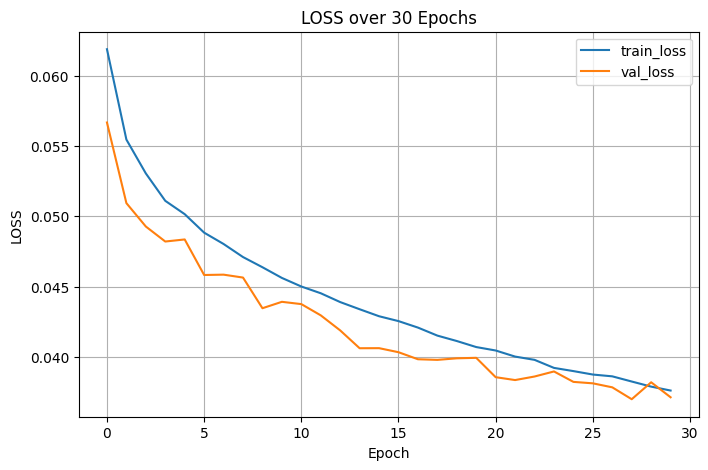

Minimal VAL LOSS: 0.0370


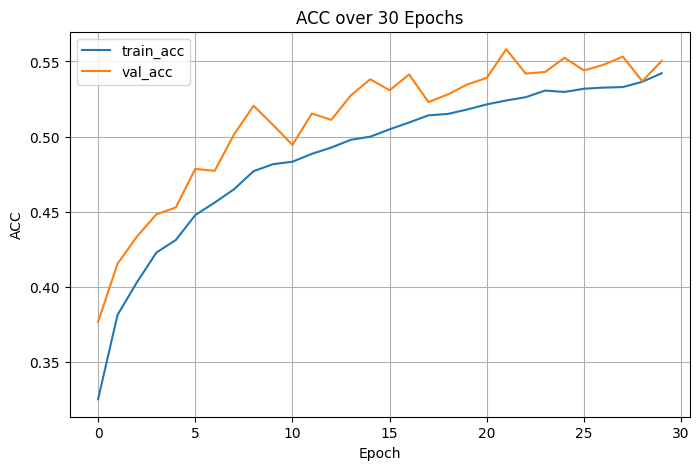

Best VAL ACC: 0.5582


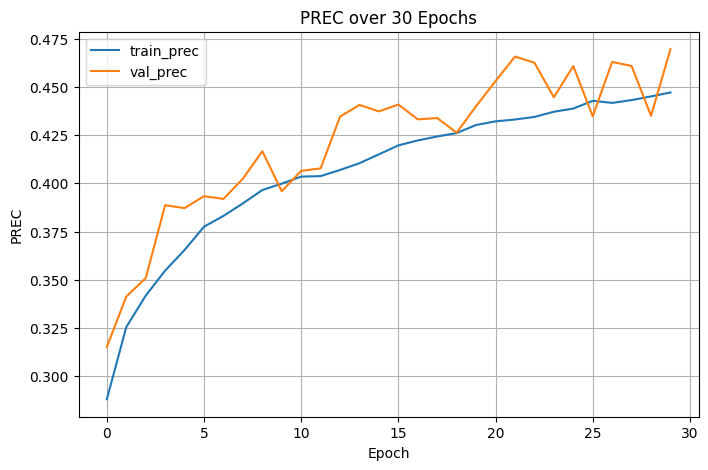

Best VAL PREC: 0.4695


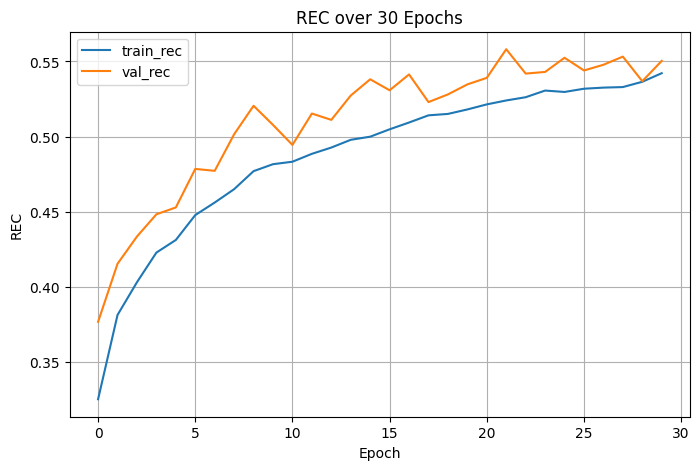

Best VAL REC: 0.5582


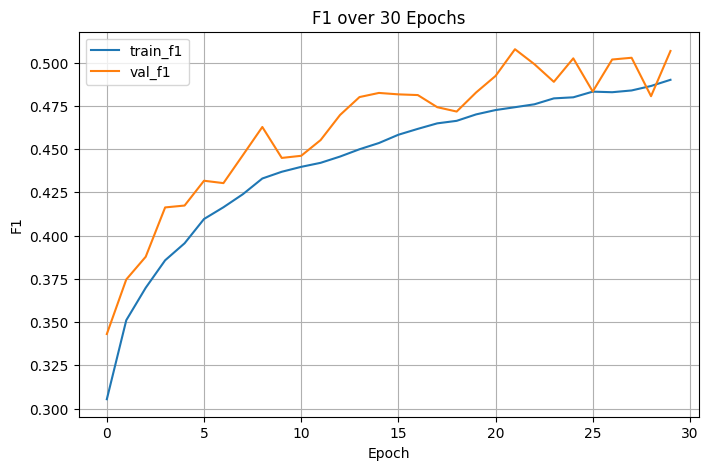

Best VAL F1: 0.5077


In [ ]:
prediction_csv_path = "/content/drive/MyDrive/Colab Notebooks/GEOG0125-Data/predictions.csv"
history_path = "/content/drive/MyDrive/Colab Notebooks/GEOG0125-Data/PPMNet_training_history_final.csv"
history_df = pd.read_csv(history_path)

metrics = ['loss', 'acc', 'prec', 'rec', 'f1']

# Create Plots for each metrics
for metric in metrics:
    plt.figure(figsize=(8, 5))
    plt.plot(history_df[metric], label=f"train_{metric}") #train line chart
    plt.plot(history_df[f"val_{metric}"], label=f"val_{metric}") #test line chart
    plt.xlabel("Epoch")
    plt.ylabel(metric.upper())
    plt.title(f"{metric.upper()} over 30 Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print best val score
    if metric != 'loss':
        best_val = np.max(history_df[f"val_{metric}"])
        print(f"Best VAL {metric.upper()}: {best_val:.4f}")
    else:
        best_val = np.min(history_df[f"val_{metric}"])
        print(f"Minimal VAL {metric.upper()}: {best_val:.4f}")

# Code source: (OpenAI, 2025a)

### 5.1 Classification Report

Based on the performance of each label, the F1 scores are 0.75, 0.47, 0.42, 0.63, and 0.17 for the classes no damage, minor damage, major damage, destroyed, and unclassified, respectively. Since the unclassified class was not considered in the study by Bai et al. (2020), comparisons will focus only on the remaining four classes. Although the overall performance in this study is understandably lower than that reported by Bai et al. (2020), the model achieved comparable results and even outperformed Bai et al. (2020) in the minor damage class.

In [ ]:
prediction_csv_path = "/content/drive/MyDrive/Colab Notebooks/GEOG0125-Data/predictions.csv"
pred_df = pd.read_csv(prediction_csv_path)
#Class Names
class_names = {
    0: "No Damage",
    1: "Minor Damage",
    2: "Major Damage",
    3: "Destroyed",
    4: "Unclassified"
}

#Generate Classification Report
report = classification_report(
    pred_df["true_label"],
    pred_df["predicted_label"],
    labels=list(class_names.keys()),
    target_names=[class_names[i] for i in class_names],
    output_dict=True,
    zero_division=0  # avoid NaN on missing classes
)

report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(3)
if "accuracy" in report_df.columns:
    report_df = report_df[["precision", "recall", "f1-score", "support"]]

print("Classification Report:")
print(report_df)

#Code source: (OpenAI, 2025g)

Classification Report:
              precision  recall  f1-score    support
No Damage         0.955   0.615     0.748  23486.000
Minor Damage      0.404   0.554     0.468   2996.000
Major Damage      0.309   0.634     0.416   2832.000
Destroyed         0.584   0.676     0.627   2645.000
Unclassified      0.096   0.713     0.168    599.000
accuracy          0.618   0.618     0.618      0.618
macro avg         0.470   0.638     0.485  32558.000
weighted avg      0.802   0.618     0.673  32558.000


### 5.2 Confusion Matrix

In terms of model evaluation, the confusion matrix in Figure X presents overall classification performance and three disaster types included in the test dataset. The matrix indicates that the model performs similarly across these disaster categories. However, it exhibits the weakest performance in distinguishing between minor and major damage labels. This limitation warrants further investigation, particularly given the constrained scope of the used test dataset, which includes only three disaster types. Previous studies have shown that different types of natural disasters can affect building structures in significantly different ways. As a result, the visual appearance of structural damage can vary greatly depending on the nature of the event (Nex et al., 2019; Zhao et al., 2024). Expanding the dataset to include a more diverse range of disaster scenarios may improve the model's ability to generalize and accurately differentiate between damage levels.

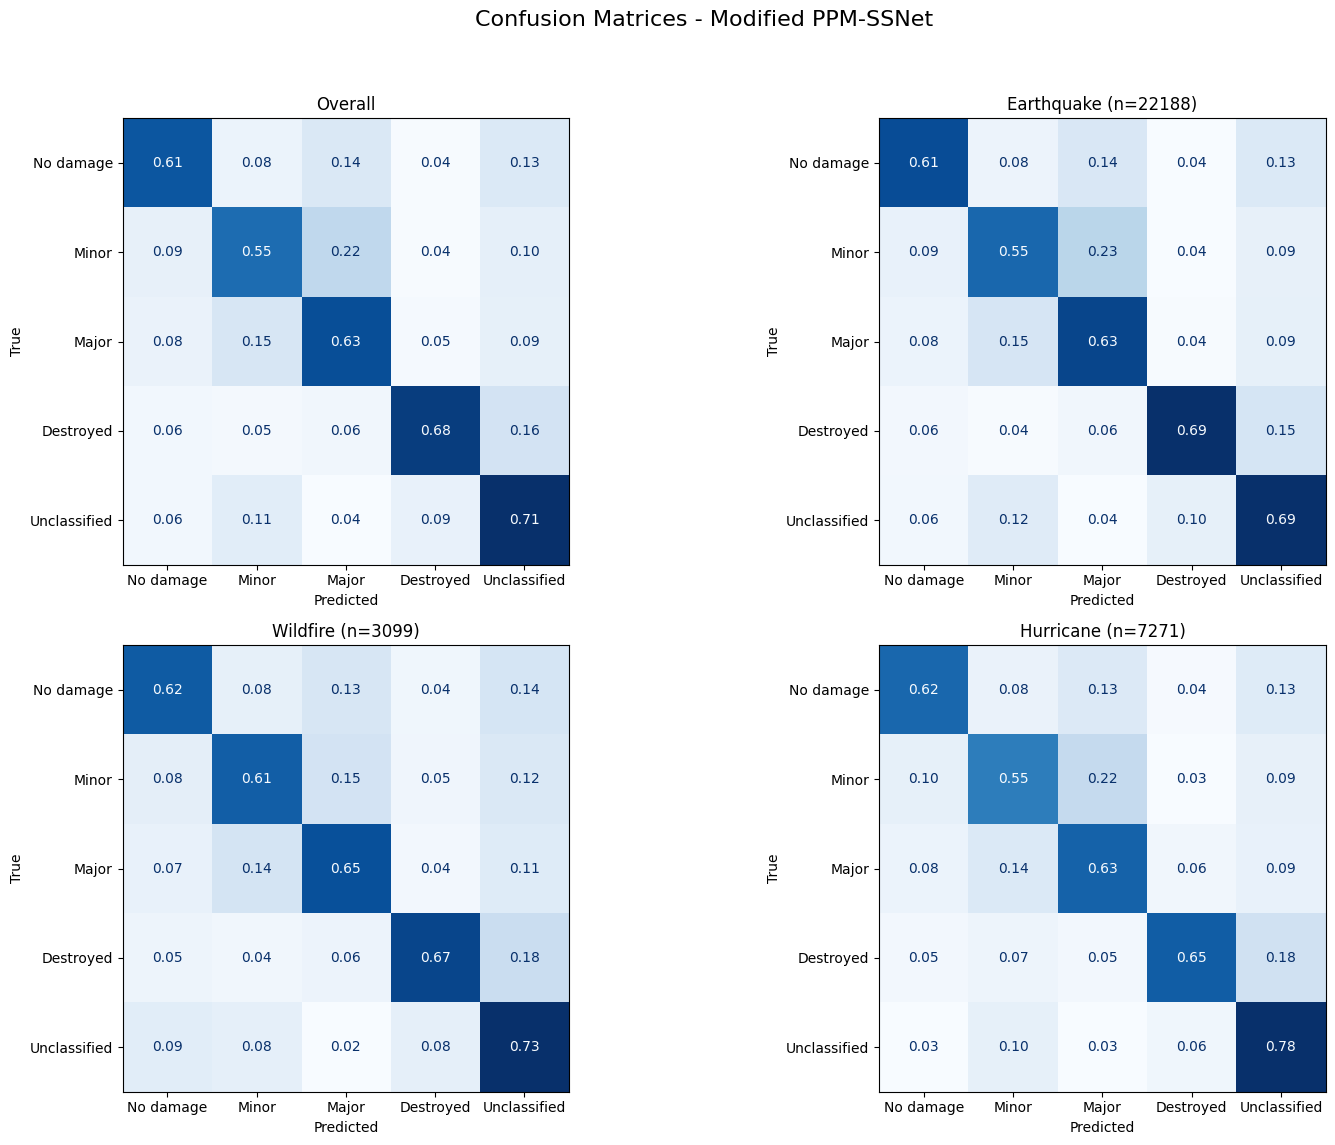

In [ ]:
train_metadata_csv_path = "/content/drive/My Drive/Colab Notebooks/GEOG0125-Data/Metadata/training_crop_metadata.csv"
prediction_csv_path = "/content/drive/MyDrive/Colab Notebooks/GEOG0125-Data/predictions.csv"
metadata_df = pd.read_csv(train_metadata_csv_path)
pred_df = pd.read_csv(prediction_csv_path)


merged_df = pd.merge(metadata_df, pred_df, on="crop_filename")
merged_df["disaster_type"] = merged_df["original_image"].apply(lambda x: x.split("_")[0])

#categorize disaster category from the image name
def categorize_disaster(name):
    if "fire" in name:
        return "Wildfire"
    elif "earthquake" in name:
        return "Earthquake"
    elif "hurricane" in name:
        return "Hurricane"
    else:
        return "Other"

merged_df["disaster_category"] = merged_df["disaster_type"].apply(categorize_disaster)


class_labels = ["No damage", "Minor", "Major", "Destroyed", "Unclassified"]

fig, axs = plt.subplots(2, 2, figsize=(16, 12)) # create 2x2 grid
fig.suptitle("Confusion Matrices - Modified PPM-SSNet", fontsize=16)
cm_overall = confusion_matrix(merged_df["true_label_y"], merged_df["predicted_label"], normalize='true') #calculates a normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_overall, display_labels=class_labels)
disp.plot(ax=axs[0, 0], cmap='Blues', values_format=".2f", colorbar=False) #top-left subplot
axs[0, 0].set_title("Overall")
axs[0, 0].set_xlabel("Predicted")
axs[0, 0].set_ylabel("True")

#Disaster-specific Plots
disasters = ["Earthquake", "Wildfire", "Hurricane"]
positions = [(0, 1), (1, 0), (1, 1)] #positions of top right, bottom left, bottom right

for disaster, (row, col) in zip(disasters, positions):
    subset = merged_df[merged_df["disaster_category"] == disaster] #Filter the DataFrame based on the disaster name from the for loop
    if subset.empty:
        axs[row, col].axis("off")
        axs[row, col].set_title(f"{disaster} (no data)")
        continue

    y_true = subset["true_label_y"]
    y_pred = subset["predicted_label"]

    cm = confusion_matrix(y_true, y_pred, normalize='true') #calculates a normalized confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=axs[row, col], cmap='Blues', values_format=".2f", colorbar=False)
    axs[row, col].set_title(f"{disaster} (n={len(subset)})")
    axs[row, col].set_xlabel("Predicted")
    axs[row, col].set_ylabel("True")


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#Code source: (OpenAI, 2025f)


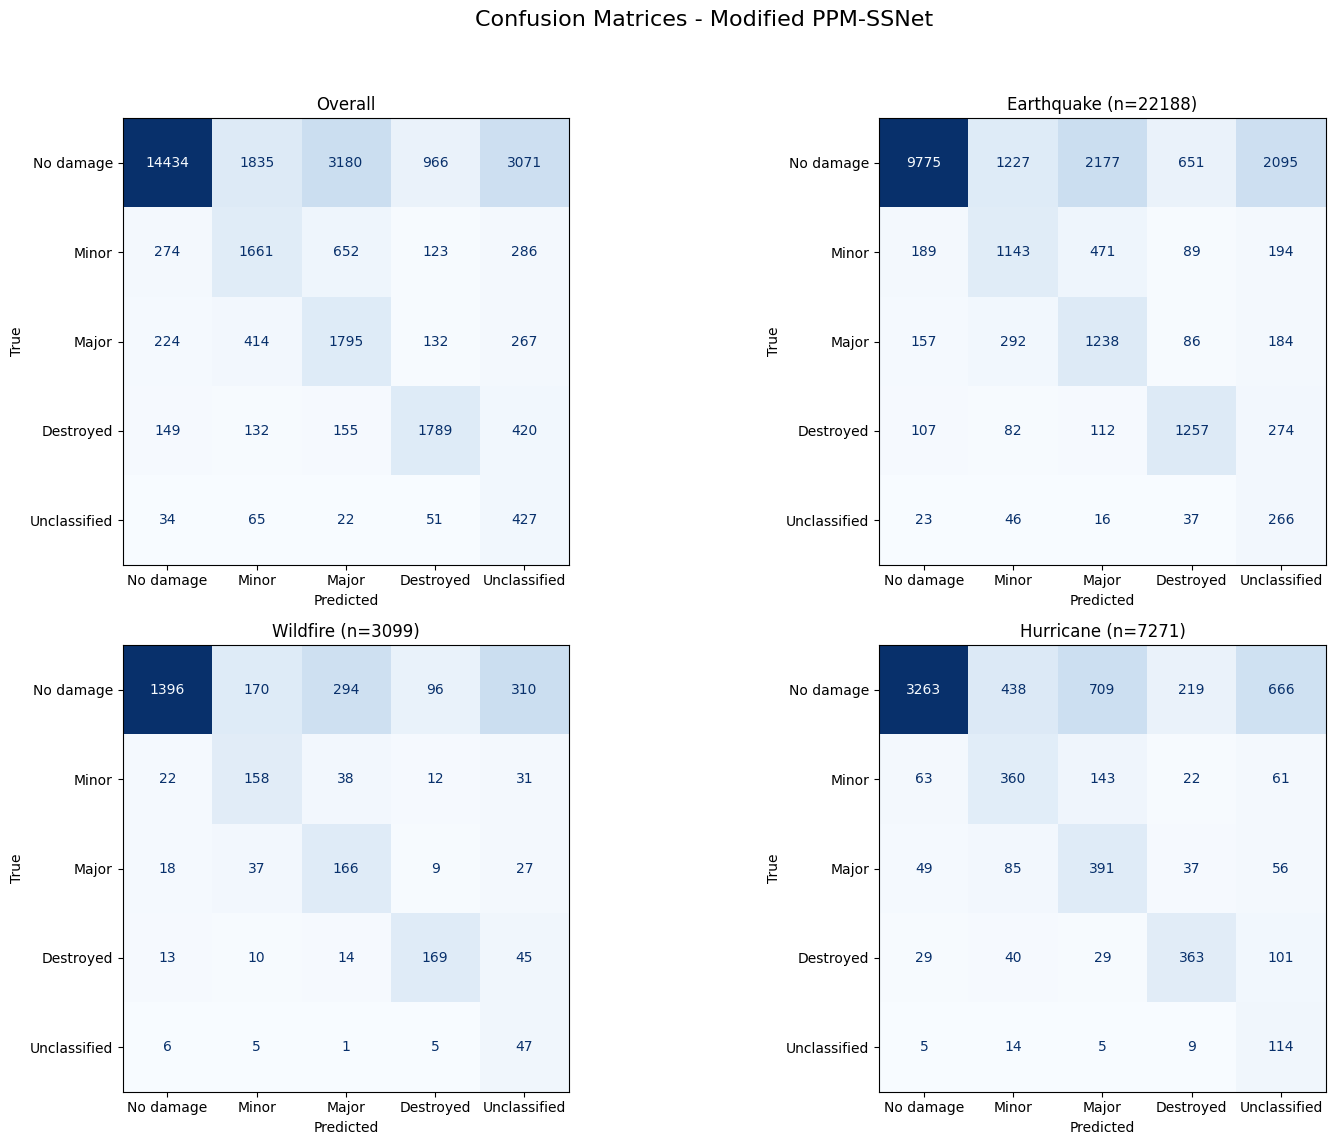

In [ ]:
# Load data
train_metadata_csv_path = "/content/drive/My Drive/Colab Notebooks/GEOG0125-Data/Metadata/training_crop_metadata.csv"
prediction_csv_path = "/content/drive/MyDrive/Colab Notebooks/GEOG0125-Data/predictions.csv"
metadata_df = pd.read_csv(train_metadata_csv_path)
pred_df = pd.read_csv(prediction_csv_path)

# Merge and categorize
merged_df = pd.merge(metadata_df, pred_df, on="crop_filename")
merged_df["disaster_type"] = merged_df["original_image"].apply(lambda x: x.split("_")[0])

def categorize_disaster(name):
    if "fire" in name:
        return "Wildfire"
    elif "earthquake" in name:
        return "Earthquake"
    elif "hurricane" in name:
        return "Hurricane"
    else:
        return "Other"

merged_df["disaster_category"] = merged_df["disaster_type"].apply(categorize_disaster)

# Class labels
class_labels = ["No damage", "Minor", "Major", "Destroyed", "Unclassified"]

# Create plot grid
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Confusion Matrices - Modified PPM-SSNet", fontsize=16)

# Overall confusion matrix (unnormalized)
cm_overall = confusion_matrix(merged_df["true_label_y"], merged_df["predicted_label"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_overall, display_labels=class_labels)
disp.plot(ax=axs[0, 0], cmap='Blues', values_format='d', colorbar=False)
axs[0, 0].set_title("Overall")
axs[0, 0].set_xlabel("Predicted")
axs[0, 0].set_ylabel("True")

# Disaster-specific plots
disasters = ["Earthquake", "Wildfire", "Hurricane"]
positions = [(0, 1), (1, 0), (1, 1)]

for disaster, (row, col) in zip(disasters, positions):
    subset = merged_df[merged_df["disaster_category"] == disaster]
    if subset.empty:
        axs[row, col].axis("off")
        axs[row, col].set_title(f"{disaster} (no data)")
        continue

    y_true = subset["true_label_y"]
    y_pred = subset["predicted_label"]

    cm = confusion_matrix(y_true, y_pred)  # Not normalized
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=axs[row, col], cmap='Blues', values_format='d', colorbar=False)
    axs[row, col].set_title(f"{disaster} (n={len(subset)})")
    axs[row, col].set_xlabel("Predicted")
    axs[row, col].set_ylabel("True")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
#Code source: (OpenAI, 2025f)

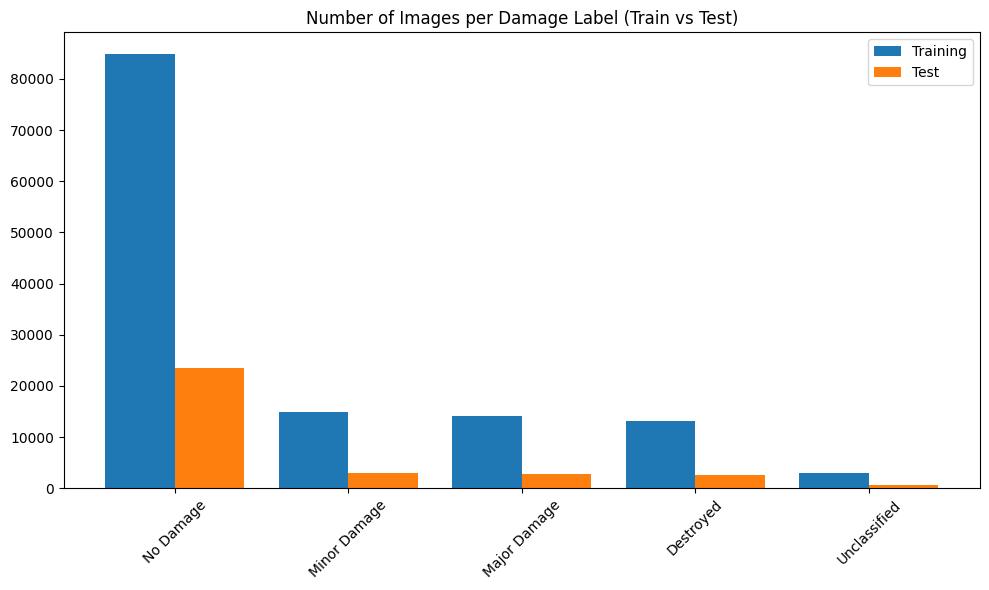

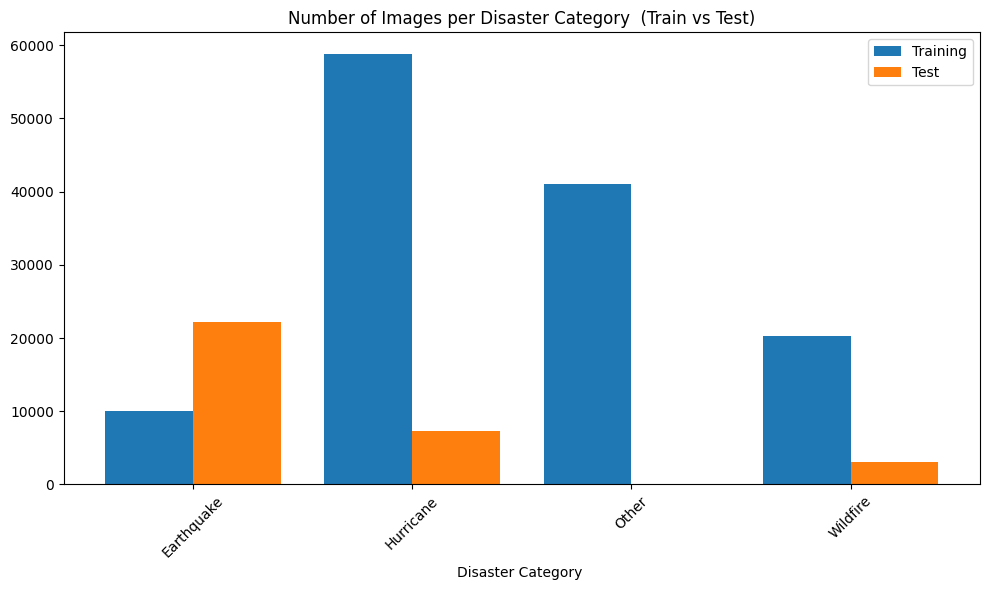

In [ ]:
metadata_df["disaster_type"] = metadata_df["original_image"].apply(lambda x: x.split("_")[0])
metadata_df["disaster_category"] = metadata_df["disaster_type"].apply(categorize_disaster)

class_names = {
    0: "No Damage",
    1: "Minor Damage",
    2: "Major Damage",
    3: "Destroyed",
    4: "Unclassified"
}

# Split training and test datasets for bar graphs
train_bar_df = metadata_df[~metadata_df['crop_filename'].isin(merged_df['crop_filename'])]
test_bar_df = merged_df

# First bar chart: Number of pictures per damage label
damage_labels = sorted(metadata_df['true_label'].dropna().unique()) #unique damage label values

train_damage_counts = train_bar_df['true_label'].value_counts().reindex(damage_labels, fill_value=0)
test_damage_counts = test_bar_df['true_label_y'].value_counts().reindex(damage_labels, fill_value=0)

x_labels = [class_names[label] for label in damage_labels] #get the class names
x = range(len(damage_labels)) #index for x-axis

plt.figure(figsize=(10, 6))
plt.bar(x, train_damage_counts, width=0.4, label='Training', align='center') # bar for training dataset count
plt.bar([i + 0.4 for i in x], test_damage_counts, width=0.4, label='Test', align='center') # bar for test dataset count
plt.xticks([i + 0.2 for i in x], x_labels, rotation=45)
plt.title('Number of Images per Damage Label (Train vs Test)')
plt.legend()
plt.tight_layout()
plt.show()

# Second bar chart: Number of pictures per disaster category
disaster_category = sorted(metadata_df['disaster_category'].dropna().unique()) #unique damage label values

train_disaster_counts = train_bar_df['disaster_category'].value_counts().reindex(disaster_category , fill_value=0)
test_disaster_counts = test_bar_df['disaster_category'].value_counts().reindex(disaster_category , fill_value=0)

x = range(len(disaster_category)) #index for x-axis

plt.figure(figsize=(10, 6))
plt.bar(x, train_disaster_counts, width=0.4, label='Training', align='center') # bar for training dataset count
plt.bar([i + 0.4 for i in x], test_disaster_counts, width=0.4, label='Test', align='center') # bar for test dataset count
plt.xticks([i + 0.2 for i in x], disaster_category, rotation=45)
plt.xlabel('Disaster Category ')
plt.title('Number of Images per Disaster Category  (Train vs Test)')
plt.legend()
plt.tight_layout()
plt.show()

# Code source: (OpenAI, 2025m)


### 5.3 Model Mask Visualisation

To evaluate the model's generalization capability, three 1024×1024 images, which are excluded from the original set of 2,799 images used during training and testing, were selected for additional testing. These images were introduced to the trained model to assess its performance on entirely unseen data. The resulting visualizations demonstrate that the model maintained a high level of predictive accuracy, with outputs largely consistent with the confusion matrices discussed in the previous section. However, the model exhibited some difficulty distinguishing between minor and major damage in buildings affected by the earthquake, suggesting a potential area for further refinement.

In [ ]:
#loading folder
!rm -rf /content/test_classification_output
!mkdir -p /content/test_classification_output
!unzip -q "test_classification_output.zip" -d /content/test_classification_output
if os.path.exists("/content/test_classification_output/test_classification_output"):
    !mv /content/test_classification_output/test_classification_output/* /content/test_classification_output/
    !rm -rf /content/test_classification_output/test_classification_output

train_dir = "/content/training_classification_output"
test_dir = "/content/test_classification_output"
filtered_csv_path = "/content/drive/My Drive/Colab Notebooks/GEOG0125-Data/Filtered_New_Test_Set.csv"
output_csv_path = "/content/drive/MyDrive/Colab Notebooks/GEOG0125-Data/new_test_predictions.csv"


# filtered filenames of the 3 images that will be used for mask visualisation
filtered_df = pd.read_csv(filtered_csv_path, header=None)
filtered_df.columns = ['filename']  # rename the column to something usable
allowed_filenames = set(filtered_df["filename"].astype(str)) #Converts all filenames to strings


#Filtered Dataset based on allowed filenames
full_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
filtered_indices = [
    i for i, (path, label) in enumerate(full_dataset.samples) #get the label of imagefolder
    if os.path.join(str(label), os.path.basename(path)) in allowed_filenames #join the label and the image name eg. 0/1000.png and check it inside allowed_filenames
]

filtered_dataset = Subset(full_dataset, filtered_indices)
filtered_loader = DataLoader(filtered_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUMWORKERS)

# === Run Model on Filtered Set ===
PPMNet_model.eval() # eval mode
all_preds, all_targets, all_filenames = [], [], []

# Extract filenames from filtered Subset
image_paths = [full_dataset.samples[i][0] for i in filtered_indices]

with torch.no_grad():
    for i, (X, y) in enumerate(tqdm(filtered_loader, desc="Predicting")): #loops through the filtered dataset
        X = X.to(device)
        outputs = PPMNet_model(X) #run the filtered dataset that have not been used before for the trained model
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        targets = y.numpy()

        start = i * BATCH_SIZE
        end = start + len(y)
        filenames = [os.path.basename(p) for p in image_paths[start:end]]

        all_preds.extend(preds)
        all_targets.extend(targets)
        all_filenames.extend(filenames)

# === Save Predictions ===
pred_df = pd.DataFrame({
    "crop_filename": all_filenames,
    "true_label": all_targets,
    "predicted_label": all_preds
})

if not os.path.exists(output_csv_path):
    pred_df.to_csv(output_csv_path, index=False)
    print(f"Predictions saved to: {output_csv_path}")
else:
    print(f"Predictions NOT saved — file already exists at: {output_csv_path}")


#Code source: (OpenAI, 2025h)


/content
unzip:  cannot find or open test_classification_output.zip, test_classification_output.zip.zip or test_classification_output.zip.ZIP.


FileNotFoundError: Couldn't find any class folder in /content/test_classification_output.

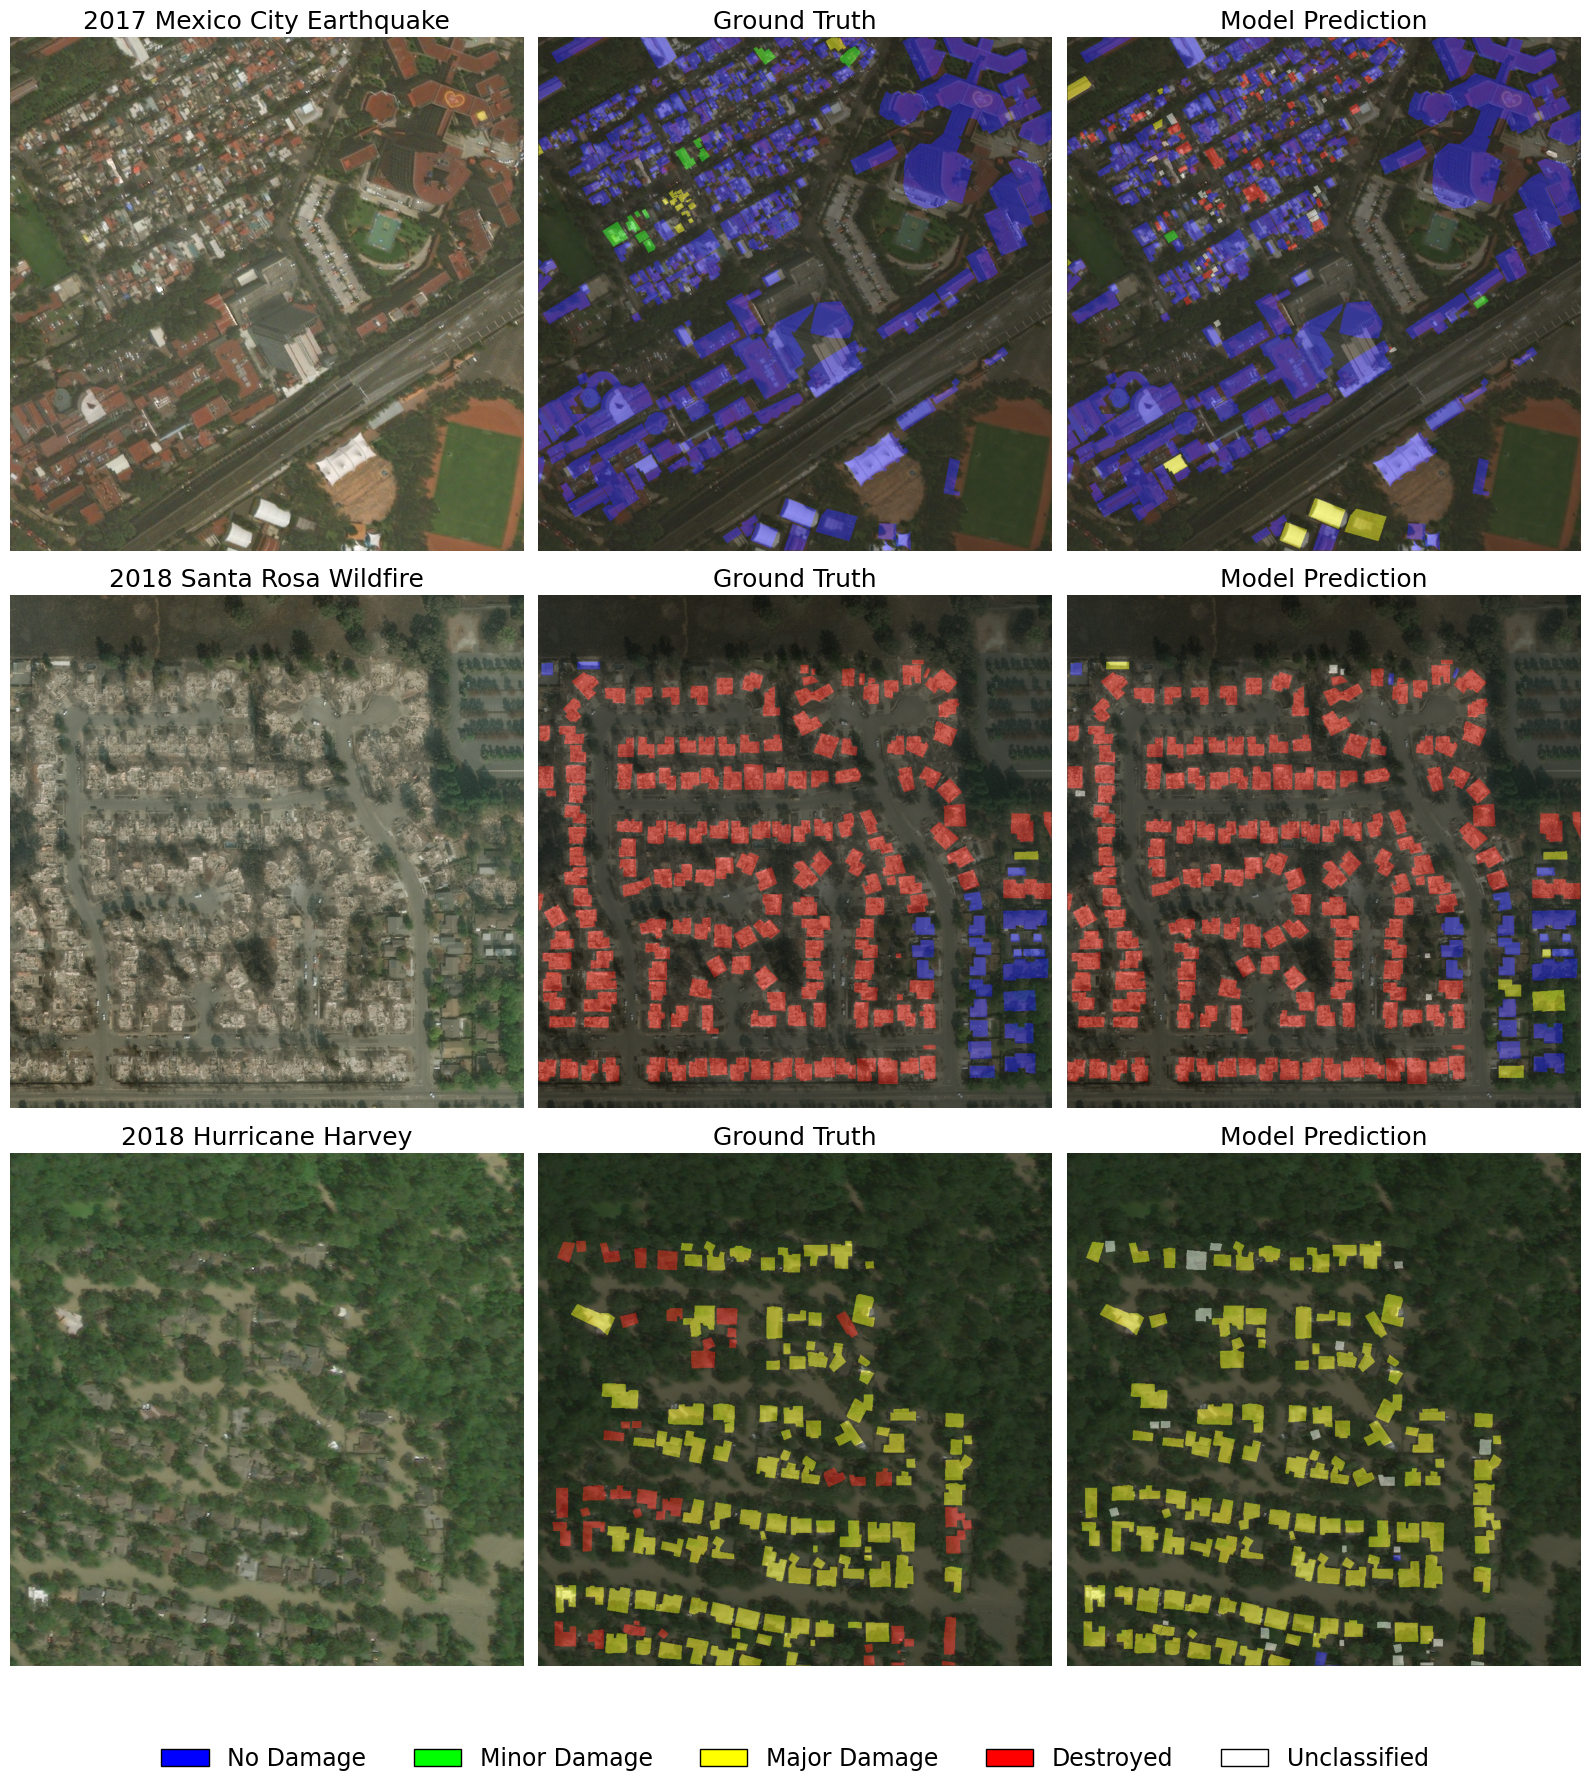

In [ ]:
metadata_csv_path = "/content/drive/My Drive/Colab Notebooks/GEOG0125-Data/Metadata/test_crop_metadata.csv"
train_images_path = "/content/drive/My Drive/Colab Notebooks/GEOG0125-Data/test_images_labels_targets/test/images/"
prediction_csv_path = "/content/drive/MyDrive/Colab Notebooks/GEOG0125-Data/new_test_predictions.csv"

#Disaster Image Targets
disaster_image_mapping = {
    "mexico-earthquake_00000069_post_disaster.png": "2017 Mexico City Earthquake",
    "santa-rosa-wildfire_00000089_post_disaster.png": "2018 Santa Rosa Wildfire",
    "hurricane-harvey_00000364_post_disaster.png": "2018 Hurricane Harvey"
}
images_of_interest = list(disaster_image_mapping.keys())

#Load and Merge Metadata & Predictions
metadata_df = pd.read_csv(metadata_csv_path)
pred_df = pd.read_csv(prediction_csv_path)
new_train_merged_df = pd.merge(metadata_df, pred_df, on="crop_filename")

#Color key
colors = {
    0: (0, 0, 255),       # No damage - blue
    1: (0, 255, 0),       # Minor damage - green
    2: (255, 255, 0),     # Major damage - yellow
    3: (255, 0, 0),       # Destroyed - red
    4: (255, 255, 255),   # Unclassified - white
}

color_labels = {
    0: "No Damage",
    1: "Minor Damage",
    2: "Major Damage",
    3: "Destroyed",
    4: "Unclassified"
}

def create_colored_mask(mask_array):
    h, w = mask_array.shape #height and width of the mask
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8) #intially set all pixel values set to 0
    for cls, color in colors.items():
        if cls == 255:
            continue
        rgb_mask[mask_array == cls] = color #paint the corresponding color when mask_array equals cls
    return rgb_mask

def poly_to_mask(poly, shape):
    mask = np.zeros(shape, dtype=np.uint8) #initializes a blank mask filled with zeros
    if not poly.is_valid: #clean or fix invalid geometries
        poly = poly.buffer(0)
    if not poly.is_empty and isinstance(poly, Polygon):
        coords = np.array(poly.exterior.coords) #gets the outline of the polygon as a list of coordinate pairs
        rr, cc = draw_polygon(coords[:, 1], coords[:, 0], shape) #convert the list of coordinates into row and column pixel
        rr = np.clip(rr, 0, shape[0] - 1) #ensures all the pixel indices stay within the image boundaries
        cc = np.clip(cc, 0, shape[1] - 1) #ensures all the pixel indices stay within the image boundaries
        mask[rr, cc] = 1 #marking building as 1
    return mask

# === Plot Setup ===
fig, axs = plt.subplots(len(images_of_interest), 3, figsize=(16, 6 * len(images_of_interest))) #creates 3 subplots with height=16 inch and width 18 inch

for i, image_name in enumerate(images_of_interest): #loops through 3 selected images
    disaster_label = disaster_image_mapping[image_name]
    img_path = os.path.join(train_images_path, image_name) #get the image from the directory

    base_img = Image.open(img_path).convert("RGB") #Loads the image using PIL and ensures it’s in RGB format
    base_img_np = np.array(base_img.resize((1024, 1024))) #Make sure image in its original 1024x1024 pixels and converts it to a NumPy array
    width, height = base_img.size #gets the width and height of the image

    gt_mask = np.full((height, width), fill_value=255, dtype=np.uint8) #Initializes empty mask for ground truth
    pred_mask = np.full_like(gt_mask, fill_value=255) #Initializes empty mask for prediction

    image_crops = new_train_merged_df[new_train_merged_df["original_image"] == image_name] #filter the merged_df with the current selected image name

    for _, row in image_crops.iterrows(): #iterates each row of cropped 64x64 images based on the current selected image name
        if pd.isna(row["polygon_wkt"]):
            continue
        try:
            poly = wkt.loads(row["polygon_wkt"]) #Converts the WKT into polygon
            mask = poly_to_mask(poly, (height, width)) #applied poly_to_mask function

            gt_cls = int(row["true_label_y"]) #get true damage class label
            pred_cls = int(row["predicted_label"]) #get prediction damage class label

            gt_mask[mask == 1] = gt_cls #set all locations where mask is 1 to the same value of gt_cls
            pred_mask[mask == 1] = pred_cls #set all locations where mask is 1 to the same value of pred_cls
        except Exception as e:
            print(f"Error in polygon for {row['crop_filename']}: {e}")
            continue

    gt_overlay = (0.6 * base_img_np + 0.4 * create_colored_mask(gt_mask)).astype(np.uint8) #blends the base image with the color mask
    pred_overlay = (0.6 * base_img_np + 0.4 * create_colored_mask(pred_mask)).astype(np.uint8) #blends the base image with the color mask

    axs[i, 0].imshow(base_img_np)
    axs[i, 0].set_title(disaster_label, fontsize=18)
    axs[i, 0].axis("off")

    axs[i, 1].imshow(gt_overlay)
    axs[i, 1].set_title("Ground Truth", fontsize=18)
    axs[i, 1].axis("off")

    axs[i, 2].imshow(pred_overlay)
    axs[i, 2].set_title("Model Prediction", fontsize=18)
    axs[i, 2].axis("off")

#color legend
from matplotlib.patches import Patch
legend_patches = [
    Patch(facecolor=np.array(colors[k]) / 255, edgecolor='black', label=color_labels[k]) #Converts the RGB values from 0–255 scale to 0–1
    for k in colors
]

fig.legend(
    handles=legend_patches,
    loc='lower center',
    ncol=len(colors),
    fontsize=17,
    frameon=False #hides frames
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

# Code source: (OpenAI, 2025i)


## 6.0 Limitation & Conclusion
In this study, the xBD dataset is utilized with a simplified approach that differs from the original PPM-SSNet model proposed by Bai et al. (2020). After training for 30 epochs, the model achieved slightly above 50% accuracy and F1 scores on both the training and test datasets. Evaluating performance by damage classification, the F1 scores were 0.75, 0.47, 0.42, 0.63, and 0.17 for the categories no damage, minor damage, major damage, destroyed, and unclassified, respectively. The model demonstrated competitive results and, in some cases, outperformed the original implementation by Bai et al. (2020).

However, the study presents several limitations, two of which are particularly noteworthy.First, the test set used in this research is limited to only three disaster types. This restriction is due to the stratified sampling method used to ensure all damage classes were represented in the test set. As a result, disaster types such as tsunamis, floods, and volcanic eruptions, which are available in the full xBD dataset—were not included. Furthermore, there are disaster types not present in the xBD dataset to begin with, such as landslides and avalanches. Including a broader range of disaster scenarios is crucial, as different natural and human-induced disasters produce distinct impacts on building structures, and the visible damage patterns can vary significantly (Zhao et al., 2024).

Second, due to limitations in both computational resources and time, the study only utilized 2,799 images from the xBD dataset, despite the availability of an additional 1,866 images that could have been included for model training and validation. More importantly, this research did not incorporate a building segmentation task, which has been shown to improve classification performance. Prior work (e.g., Bai et al., 2020; Chen, 2020) has demonstrated that leveraging segmentation features can enhance the model's ability to learn structural cues that are critical for accurate damage classification.

This exploratory study serves as an initial step in examining how convolutional neural networks (CNNs) can support post-disaster damage assessment. The findings underscore the potential of deep learning models to assist governmental agencies and first responders in making timely and informed decisions during disaster events.

## 7.0 References

Adinata, M.F. (2023). Damage Assessment. [online] Github. Available at: https://github.com/Faisaladinata/damage-assessment.

Bai, Y., Hu, J., Su, J., Liu, X., Liu, H., He, X., Meng, S., Mas, E. and Koshimura, S. (2020). Pyramid Pooling Module-Based Semi-Siamese Network: A Benchmark Model for Assessing Building Damage from xBD Satellite Imagery Datasets. Remote Sensing, 12(24). doi:https://doi.org/10.3390/rs12244055.

Benedict, R., Winartio, R.B., Adinata, M.F. and Irwansyah, E. (2024). Comparison on Difference Deep Learning Models for Building Damage Assessment using xBD Dataset. In: 2024 Arab ICT Conference (AICTC). IEEE, pp.181–186.

Chen, J. (2020a). pytorch-lars. [online] Github. Available at: https://github.com/JosephChenHub/pytorch-lars/blob/master/resnet.py.

Chen, X. (2020b). Using Satellite Imagery to Automate Building Damage Assessment: A case study of the xBD dataset. In: Institute of Industrial and Systems Engineers Annual Conference.Defense Innovation Unit (n.d.). xView2. [online] xview2.org. Available at: https://xview2.org/dataset.

Engelberts, J. (2018). Squeeze-Excitation-PyTorch. [online] Github. Available at: https://github.com/jonnedtc/Squeeze-Excitation-PyTorch/blob/master/networks.

py.Hug, N. (2023). resnet.py. [online] Github. Available at: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py.

Law, S. and Lin, A. (2025). GEOG0125 Computer Lab 8. [online] GEOG0125: Advanced Topics in Social and Geographic Data Science. Available at: https://colab.research.google.com/drive/13FOgYW_t4euU_C-Y6W_VMk4Gk2OTBRbq.

Li, B., Hua, Y., Liu, Y. and Lu, M. (2021). Dilated Fully Convolutional Neural Network for Depth Estimation from a Single Image. Advances in Science, Technology and Engineering Systems Journal, 5(5). doi:https://doi.org/10.25046/aj060292.

mlyg (2022). unified-focal-loss. [online] Github. Available at: https://github.com/mlyg/unified-focal-loss/blob/main/loss_functions.py.

Nex, F., Duarte, D., Tonolo, F.G. and Kerle, N. (2019). Structural Building Damage Detection with Deep Learning: Assessment of a State-of-the-Art CNN in Operational Conditions. Remote Sensing, 11(23). doi:https://doi.org/10.3390/rs11232765.

OpenAI (2025a). can you create this graph as well ‘loss_array = zip(train_loss_array,test_loss_array) loss_df=pd.DataFrame(loss_array,columns=[“train”,“test”]) loss_df.plot() print(“minimal test loss:” + str(np.min(test_loss_array)))’ but for all metrics. [online] ChatGPT (April, 18 2025 Version). Available at: https://chatgpt.com/c/67f10d2d-ba30-800a-b3c9-4789ea5e3806.

OpenAI (2025b). can you explain in detail about this code "self.layer2 = ResidualBlockV2(16, 32, stride=2, dilation=1)  # RB′ self.layer3 = ResidualBlock(32, 32, stride=1, dilation=1). [online] ChatGPT (April, 18 2025 Version). Available at: https://chatgpt.com/c/67f21151-18ec-800a-81e7-5feff8a55e94.

OpenAI (2025c). can you explain this "# dataset param DATA_PATH = ‘../output_mask2/’ IMG_SIZE = (224, 224) NCLASS = 4 BATCH_SIZE = 32 VAL_SPLIT = 0.15 NUMWORKERS = 4. [online] ChatGPT (April, 18 2025 Version). Available at: https://chatgpt.com/c/67f10d2d-ba30-800a-b3c9-4789ea5e3806.

OpenAI (2025d). can you improve this code "def set_parameter_requires_grad(model, feature_extracting): if feature_extracting: for param in model.parameters(): param.requires_grad = False. [online] ChatGPT (April, 18 2025 Version). Available at: https://chatgpt.com/c/67f10d2d-ba30-800a-b3c9-4789ea5e3806.

OpenAI (2025e). can you improve this code so that I can in coorporate the label from json files (for post disaster) and make it so the extracted data can be use to visualize this. [online] ChatGPT (April, 18 2025 Version). Available at: https://chatgpt.com/c/67f10d2d-ba30-800a-b3c9-4789ea5e3806.

OpenAI (2025f). can you make this "rom sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay. [online] ChatGPT (April, 18 2025 Version). Available at: https://chatgpt.com/c/67f10d2d-ba30-800a-b3c9-4789ea5e3806.

OpenAI (2025g). do you know how else I can improve the acc of my model . [online] ChatGPT (April, 18 2025 Version). Available at: https://chatgpt.com/c/67f10d2d-ba30-800a-b3c9-4789ea5e3806.

OpenAI (2025h). from this code "%cd /content # Step 2: Clean and create destination folders !rm -rf /content/test_classification_output !mkdir -p /content/test_classification_output. [online] ChatGPT (April, 18 2025 Version). Available at: https://chatgpt.com/c/67f10d2d-ba30-800a-b3c9-4789ea5e3806.

OpenAI (2025i). from this code "import os import pandas as pd import numpy as np import matplotlib.pyplot as plt from PIL import Image import torch import torchvision.transforms as transforms # Paths metadata_csv_path = "/content/drive/My Drive/Colab Notebooks/GEOG0125-Data/training_crop_metadata.csv. [online] ChatGPT (April, 18 2025 Version). Available at: https://chatgpt.com/c/67f10d2d-ba30-800a-b3c9-4789ea5e3806.

OpenAI (2025j). got it! this is the first code chunk of extracting buildings: "import os from tqdm import tqdm from PIL import Image import numpy as np OUTPUT_PATH = ‘output_mask2/’ MASK_PATH = ‘train/targets/’ IMG_PATH = ‘train/images/’ CROP_SIZE = (64, 64) if not os.path.isdir(OUTPUT_PATH): os.mkdir(OUTPUT_PATH) imgs_path = os.listdir(IMG_PATH) imgs_path = [x for x in imgs_path if (‘post’) in x] masks_path = os.listdir(MASK_PATH) masks_path = [x for x in masks_path if (‘post’) in x] print(len(imgs_path))", can you adjust to my dataset path? [online] ChatGPT (April, 18 2025 Version). Available at: https://chatgpt.com/c/67f10d2d-ba30-800a-b3c9-4789ea5e3806.

OpenAI (2025k). how to sanity check on these codes "raw_dataset = datasets.ImageFolder(root=TRAINING_DATASET). [online] ChatGPT (April, 18 2025 Version). Available at: https://chatgpt.com/c/68012c75-f998-800a-b271-76450c585821.

OpenAI (2025l). i dont think i have this yet "prediction_csv_path = ‘/content/drive/MyDrive/Colab Notebooks/GEOG0125-Data/predictions.csv’. [online] ChatGPT (April, 18 2025 Version). Available at: https://chatgpt.com/c/67f10d2d-ba30-800a-b3c9-4789ea5e38.

OpenAI (2025m). I want to make 2 bar charts. the first bar chart is to show the number of pictures of each damage label. I want to show each categories with two bars (training dataset and test dataset). The second bar chart is to show the number of pictures of each disaster type. I want to show each disaster type with two bars (training dataset and test dataset).  The training data set is all data that is in metadata_df but not in merged_df. the test dataset in all in merged_df. Can you provide a python code for this. [online] ChatGPT (April, 18 2025 Version). Available at: https://chatgpt.com/c/68012c75-f998-800a-b271-76450c585821.

OpenAI (2025n). I want to use PPM SSNET but only post disaster images as an input. [online] ChatGPT (April, 18 2025 Version). Available at: https://chatgpt.com/c/67f10d2d-ba30-800a-b3c9-4789ea5e3806.

OpenAI (2025o). if i use this "train_idx, val_idx = train_test_split(data_idx, test_size=VAL_SPLIT, random_state=100)", will the validation set have an equal distribution of all classes? [online] ChatGPT (April, 18 2025 Version). Available at: https://chatgpt.com/c/67f10d2d-ba30-800a-b3c9-4789ea5e3806?src=history_search.

OpenAI (2025p). this is a right code right to train my model "# Create model instance PPMNet_model = PPMNet(num_classes=NUM_CLASSES).to(device). [online] ChatGPT (April, 18 2025 Version). Available at: https://chatgpt.com/c/67f10d2d-ba30-800a-b3c9-4789ea5e3806.

OpenAI (2025q). this is my test set "TEST_POST_IMAGE_PATH = test_images_path TEST_POST_JSON_PATH = test_labels_path TEST_OUTPUT_PATH = os.path.join(base_path, ‘test_classification_output/’) os.makedirs(TEST_OUTPUT_PATH, exist_ok=True) CROP_SIZE=(64,64) # Debug mode. [online] ChatGPT (April, 18 2025 Version). Available at: https://chatgpt.com/c/67f10d2d-ba30-800a-b3c9-4789ea5e3806.

OpenAI (2025r). this is the focal loss function in the github "class FocalLoss(nn.Module): [online] ChatGPT (April, 18 2025 Version). Available at: https://chatgpt.com/c/67f10d2d-ba30-800a-b3c9-4789ea5e3806.

OpenAI (2025s). You said: but this is from your code ‘!unzip -q “training_classification_output-20250412T083006Z-001.zip” -d /content/training_classification_output !unzip -q “training_classification_output-20250412T083006Z-002.zip” -d /content/training_classification_output !unzip -q “training_classification_output-20250412T083006Z-003.zip” -d /content/training_classification_output’ because they all end with ‘.zip’ and not ‘.z01, .z02, etc’. [online] ChatGPT (April, 18 2025 Version). Available at: https://chatgpt.com/c/67f10d2d-ba30-800a-b3c9-4789ea5e3806?src=history_search.

Perez, H., Tah, J.H.M. and Mosavi, A. (2019). Deep Learning for Detecting Building Defects Using Convolutional Neural Networks. Sensors, 19(16). doi:https://doi.org/10.3390/s19163556.

Pi, Y., Nath, N.D. and Behzadan, A.H. (2020). Convolutional neural networks for object detection in aerial imagery for disaster response and recovery. Advanced Engineering Informatics, 43. doi:https://doi.org/10.1016/j.aei.2019.101009.

Tan, M. and Le, Q.V. (2019). EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. In: International conference on machine learning. [online] PMLR, pp.6105–6114. Available at: https://arxiv.org/pdf/1905.11946.

Wu, C., Zhang, F., Xia, J., Xu, Y., Li, G., Xie, J., Du, Z. and Liu, R. (2021). Building Damage Detection Using U-Net with Attention Mechanism from Pre- and Post-Disaster Remote Sensing Datasets. Remote Sensing, 13(5). doi:https://doi.org/10.3390/rs13050905.

Zhao, H. (2020). pspnet.py. [online] Github. Available at: https://github.com/hszhao/semseg/blob/master/model/pspnet.py.

Zhao, H., Shi, J., Qi, X., Wang, X. and Jia, J. (2017). Pyramid Scene Parsing Network. Proceedings of the IEEE conference on computer vision and pattern recognition, pp.2881–2890.

Zhao, Z., Wang, F., Chen, S., Wang, H. and Cheng, G. (2024). Deep object segmentation and classification networks for building damage detection using the xBD dataset. International Journal of Digital Earth, 17(1). doi:https://doi.org/10.1080/17538947.2024.2302577.

Zhou, J. (2019). pytorch-residual-block. [online] Github. Available at: https://github.com/trailingend/pytorch-residual-block/blob/master/main.py.